In [6]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
from time import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/bem/examples')
sys.path.append('/Users/Ben/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/ionLifetimes/electrode')
from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
    print("non-used")
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"
    print("simp used")

simp used


In [3]:
# scale to natural units (ion height)
scale = 40e-6
use_stl = True
if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0


In [4]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_mom=4, num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

In [5]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=2, inside=.2, outside=10.))
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)
# grid to evalute potential and fields at
n, s = 2*10, .1
grid = Grid(center=(0, 0, 1.5), step=(s, s, s), shape=(n, n, n))
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*", "RF"))
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
t0 = time()
list(pmap(run_job, ((job, grid, prefix) for job in jobs)))  # In python 3, convert map(...) to list(map(...))
print("Computing time: %f s"%(time()-t0))

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4
Computing time: 9.640707 s


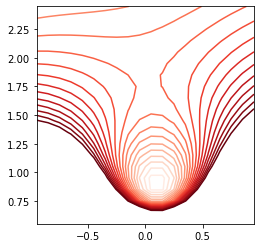

In [52]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]//2]    # In python 3, use //
p = p[p.shape[0]//2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

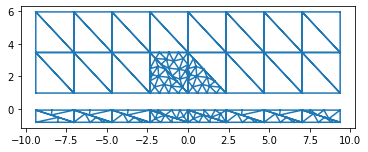

In [46]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [33]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()
"done"

'done'

In [31]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)

In [36]:
import scipy.constants as ct
l = 40e-6 # length scale
o = 100e6*2*np.pi # rf frequency
m = 25*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
rf_scale = s.rf_scale(m,q,l,o)

s["RF"].rf = 25. # peak rf voltage
method = 'Newton-CG'
x0 = s.minimum((0, 0, 1.),method=method)
# , min_method=method
for _ in s.analyze_static(x0, m=m, l=l, o=o):
    print(_)

parameters:
 f=100 MHz, m=25 amu, q=1 qe, l=40 µm, scale=0.0391 V'/V_SI
corrdinates:
 analyze point: [-1.16091008e-04  1.00178719e-01  8.97738394e-01]
               ([-4.64364032e-03  4.00714876e+00  3.59095357e+01] µm)
 minimum is at offset: [6.68117778e-08 1.53483080e-07 1.95463379e-09]
                      ([2.67247111e-06 6.13932321e-06 7.81853515e-08] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 2.2e-05 eV
 saddle offset: [-5.49389139e-03 -1.07559557e-05 -4.46785895e-06]
               ([-2.19755655e-01 -4.30238229e-04 -1.78714358e-04] µm)
 saddle height: 3e-08 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [-1.00128273e-05 -2.30019262e-05 -2.92933534e-07] eV/l
           ([-0.25032068 -0.57504816 -0.00732334] eV/m)
modes:
 pp+dc normal curvatures: [-2.20282635e-04  1.78543455e+02  1.78583663e+02]
 motion is bounded: False
 pseudopotential modes:
  a: nan MHz, [9.99997701e-01 1.98559729e-03 8.09576447e-04]
  b: 104.4 MHz, [-4.97958089e-

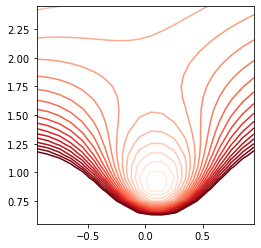

In [62]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2000e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds)